In [2]:
import warnings
warnings.filterwarnings('ignore')

import modulo_conn_sql as mcq
import numpy as np
import pandas as pd 
import datetime 
import matplotlib.pyplot as plt
from pandas.tseries.offsets import MonthEnd
from pandas.tseries.offsets import MonthBegin
import math

import matplotlib.pyplot as plt
import seaborn as sns

In [3]:
def conectarSQL():
    conn = mcq.ConexionSQL()
    cursor = conn.getCursor()
    return cursor

#Query BD SQL-Server Cemex
def querySQL(query, parametros):
    #Conectar con base sql y ejecutar consulta
    cursor = conectarSQL()
    try:
        cursor.execute(query, parametros)
        #obtener nombre de columnas
        names = [ x[0] for x in cursor.description]
        
        #Reunir todos los resultado en rows
        rows = cursor.fetchall()
        resultadoSQL = []
            
        #Hacer un array con los resultados
        while rows:
            resultadoSQL.append(rows)
            if cursor.nextset():
                rows = cursor.fetchall()
            else:
                rows = None
                
        #Redimensionar el array para que quede en dos dimensiones
        resultadoSQL = np.array(resultadoSQL)
        resultadoSQL = np.reshape(resultadoSQL, (resultadoSQL.shape[1], resultadoSQL.shape[2]) )
    finally:
            if cursor is not None:
                cursor.close()
    return pd.DataFrame(resultadoSQL, columns = names)

def first_n_digits(num):
    return int(num // 10 ** (int(math.log(num, 10))))

In [44]:
pais='Colombia'
inicioHistoria = datetime.datetime(2020, 11, 1) #'2013-05-01'
finHistoria = datetime.datetime(2020, 12 , 31)
#Consulta de datos en la base SQL
despachosSQL = querySQL(  "{CALL SCAC_AP8_BaseForecast (?,?,?)}", (pais, inicioHistoria.strftime("%Y-%m-%d"), finHistoria.strftime("%Y-%m-%d") ) )
#arreglo de formatos
despachosSQL['totalEntregado'] = despachosSQL['totalEntregado'].astype(float)
despachosSQL['FechaEntrega'] = pd.to_datetime(despachosSQL['FechaEntrega'])
despachosSQL['year-month'] = despachosSQL['FechaEntrega'].dt.to_period('M')

df_nombre_cluster = querySQL("SELECT * FROM SCAC_AT1_NombreCluster WHERE Pais = ?" , (pais))
despachosSQL = pd.merge(despachosSQL, df_nombre_cluster, left_on='Planta', right_on='Centro', how='inner').reset_index()

In [115]:
despachosSQL.head(50)

,index,Año,Mes,Planta,TipoPlanta,totalEntregado,Semana_Relativa,DiaSemana,FechaEntrega,DiasOperativos,...,Planta Homologada Ventas,Ventana Produccion,Pais,Cluster_Customer,Activo,ZonaComercial,GrupoGeografico,IntegracionGPS,Planeacion,Asignacion
0,0,2019,1,F001,Central,73.25,2,3,2019-01-08,1,...,PLANTA 240,11,Colombia,CENTRO,1,None,None,None,None,None
1,1,2019,1,F001,Central,333.25,2,4,2019-01-09,2,...,PLANTA 240,11,Colombia,CENTRO,1,None,None,None,None,None
2,2,2019,1,F001,Central,257.75,2,5,2019-01-10,3,...,PLANTA 240,11,Colombia,CENTRO,1,None,None,None,None,None
3,3,2019,1,F001,Central,323.75,2,6,2019-01-11,4,...,PLANTA 240,11,Colombia,CENTRO,1,None,None,None,None,None
4,4,2019,1,F001,Central,139.00,2,7,2019-01-12,5,...,PLANTA 240,11,Colombia,CENTRO,1,None,None,None,None,None
5,5,2019,1,F001,Central,324.75,3,2,2019-01-14,6,...,PLANTA 240,11,Colombia,CENTRO,1,None,None,None,None,None
6,6,2019,1,F001,Central,426.25,3,3,2019-01-15,7,...,PLANTA 240,11,Colombia,CENTRO,1,None,None,None,None,None
7,7,2019,1,F001,Central,455.75,3,4,2019-01-16,8,...,PLANTA 240,11,Colombia,CENTRO,1,None,None,None,None,None
8,8,2019,1,F001,Central,485.25,3,5,2019-01-17,9,...,PLANTA 240,11,Colombia,CENTRO,1,None,None,None,None,None
9,9,2019,1,F001,Central,357.00,3,6,2019-01-18,10,...,PLANTA 240,11,Colombia,CENTRO,1,None,None,None,None,None


In [188]:
#solo me interesa el mes y el total volumen entnregado
df = despachosSQL[['year-month', 'FechaEntrega', 'Ciudad_Cluster','totalEntregado']]
df = df.groupby(['year-month', 'FechaEntrega', 'Ciudad_Cluster']).agg({'totalEntregado': sum}).reset_index()

#creo dos columnas con el digito, uno para el encabezado de conteo y otro para contar
df['primerDigito'] = df['totalEntregado'].apply(first_n_digits)
df['primerDigito_label'] = df['primerDigito']

#conteo de primeros digitos por mes
df_count_digits = df.groupby(['year-month','primerDigito_label']).agg({'primerDigito': 'count'}).reset_index()
#conteo de total primeros digitos por mes
df_count_digits2 = df.groupby(['year-month']).agg({'primerDigito': 'count'}).reset_index()
#hago un merge para poder determinar la proporcion
df_count_digits3 = pd.merge(df_count_digits, df_count_digits2, on=['year-month'], how='inner')

#determino la proporcion de conteo de cada digito
df_count_digits3['Proporcion'] = df_count_digits3['primerDigito_x'] / df_count_digits3['primerDigito_y']

#valores de referencia de la leyB
leyb = pd.read_excel("../datos/leyb.xlsx")

#uno las proporciones obtenidas para compararlas con la ley B
df_count_digits4 = pd.merge(df_count_digits3, leyb, left_on=['primerDigito_label'], right_on=['Digito'], how='inner')

#calculo la desviacion a los valores de referencia
#df_count_digits4['Desviacion_leyB'] = ((df_count_digits4['proporcion_leyB'] - df_count_digits4['Proporcion']).abs())/df_count_digits4['proporcion_leyB']
df_count_digits4['Desviacion_leyB'] = (df_count_digits4['proporcion_leyB'] - df_count_digits4['Proporcion']).abs()
df_count_digits4

,year-month,primerDigito_label,primerDigito_x,primerDigito_y,Proporcion,Digito,proporcion_leyB,Desviacion_leyB
0,2019-01,1,112,409,0.273839,1,0.301,0.027161
1,2019-02,1,110,407,0.270270,1,0.301,0.030730
2,2019-03,1,126,408,0.308824,1,0.301,0.007824
3,2019-04,1,98,355,0.276056,1,0.301,0.024944
4,2019-05,1,123,410,0.300000,1,0.301,0.001000
...,...,...,...,...,...,...,...,...
103,2019-08,9,13,397,0.032746,9,0.046,0.013254
104,2019-09,9,16,398,0.040201,9,0.046,0.005799
105,2019-10,9,10,409,0.024450,9,0.046,0.021550
106,2019-11,9,14,415,0.033735,9,0.046,0.012265


In [189]:
df_desviacion_mensual = df_count_digits4.groupby(['year-month']).agg({'Desviacion_leyB':'median'}).reset_index()
df_desviacion_mensual

,year-month,Desviacion_leyB
0,2019-01,0.007790
1,2019-02,0.010489
2,2019-03,0.016686
3,2019-04,0.012930
4,2019-05,0.011854
5,2019-06,0.021023
6,2019-07,0.011125
7,2019-08,0.015736
8,2019-09,0.005799
9,2019-10,0.021699


In [190]:
df_desviacion_mensual['Desviacion_leyB'].mean()

0.013297574327172434

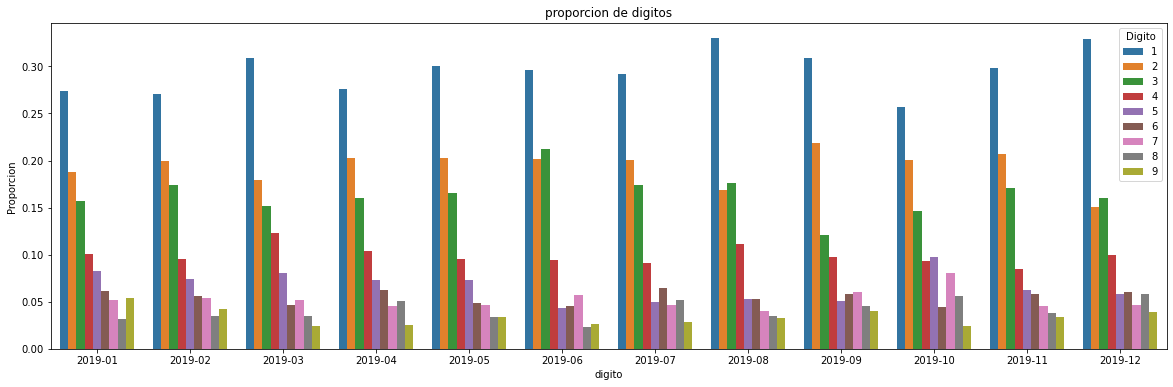

In [191]:
fig, ax = plt.subplots()
fig.set_size_inches(20, 6)
sns.barplot(x=df_count_digits4['year-month'], y = df_count_digits4['Proporcion'], hue=df_count_digits4['Digito'])
plt.xlabel('digito')
plt.ylabel('Proporcion')
plt.title('proporcion de digitos')
plt.show()

In [240]:
pais='Colombia'
nombre_version = 'ESTADISTICO_AGO_2021'
df_desagregacion = pd.read_excel("../datos/" + pais +"_" + nombre_version + ".xlsx")
df_desagregacion['FechaEntrega'] = pd.to_datetime(df_desagregacion['FechaEntrega'])
df_desagregacion['year-month'] = df_desagregacion['FechaEntrega'].dt.to_period('M')
df_desagregacion

,pais,Ciudad,Centro,PlantaUnica,FechaEntrega,M3Forecast,year-month
0,Costa Rica,Costa Rica,G202,CR-PLANTA PUENTE PIEDRA,2021-07-01,183.399879,2021-07
1,Costa Rica,Costa Rica,G212,CR-PLANTA FILADELFIA,2021-07-01,55.864159,2021-07
2,Costa Rica,Costa Rica,G202,CR-PLANTA PUENTE PIEDRA,2021-07-02,210.050866,2021-07
3,Costa Rica,Costa Rica,G212,CR-PLANTA FILADELFIA,2021-07-02,59.463132,2021-07
4,Costa Rica,Costa Rica,G202,CR-PLANTA PUENTE PIEDRA,2021-07-03,147.603214,2021-07
...,...,...,...,...,...,...,...
57,Costa Rica,Costa Rica,G212,CR-PLANTA FILADELFIA,2021-07-29,48.789914,2021-07
58,Costa Rica,Costa Rica,G202,CR-PLANTA PUENTE PIEDRA,2021-07-30,193.042064,2021-07
59,Costa Rica,Costa Rica,G212,CR-PLANTA FILADELFIA,2021-07-30,51.933138,2021-07
60,Costa Rica,Costa Rica,G202,CR-PLANTA PUENTE PIEDRA,2021-07-31,135.651091,2021-07


In [241]:
#solo me interesa el mes y el total volumen entnregado
df = df_desagregacion[df_desagregacion['M3Forecast']>=1][['year-month', 'FechaEntrega', 'Ciudad','M3Forecast']]
df = df.groupby(['year-month', 'FechaEntrega', 'Ciudad']).agg({'M3Forecast': sum}).reset_index()

#creo dos columnas con el digito, uno para el encabezado de conteo y otro para contar
df['primerDigito'] = df['M3Forecast'].apply(first_n_digits)
df['primerDigito_label'] = df['primerDigito']

#conteo de primeros digitos por mes
df_count_digits = df.groupby(['year-month','primerDigito_label']).agg({'primerDigito': 'count'}).reset_index()
#conteo de total primeros digitos por mes
df_count_digits2 = df.groupby(['year-month']).agg({'primerDigito': 'count'}).reset_index()
#hago un merge para poder determinar la proporcion
df_count_digits3 = pd.merge(df_count_digits, df_count_digits2, on=['year-month'], how='inner')

#determino la proporcion de conteo de cada digito
df_count_digits3['Proporcion'] = df_count_digits3['primerDigito_x'] / df_count_digits3['primerDigito_y']

#valores de referencia de la leyB
leyb = pd.read_excel("../datos/leyb.xlsx")

#uno las proporciones obtenidas para compararlas con la ley B
df_count_digits4 = pd.merge(df_count_digits3, leyb, left_on=['primerDigito_label'], right_on=['Digito'], how='inner')

#calculo la desviacion a los valores de referencia
#df_count_digits4['Desviacion_leyB'] = ((df_count_digits4['proporcion_leyB'] - df_count_digits4['Proporcion']).abs())/df_count_digits4['proporcion_leyB']
#df_count_digits4['Desviacion_leyB'] = (df_count_digits4['proporcion_leyB'] - df_count_digits4['Proporcion']).abs()
df_count_digits4['Desviacion_leyB'] = df_count_digits4['proporcion_leyB'] - df_count_digits4['Proporcion']
df_count_digits4

,year-month,primerDigito_label,primerDigito_x,primerDigito_y,Proporcion,Digito,proporcion_leyB,Desviacion_leyB
0,2021-07,1,12,26,0.461538,1,0.301,-0.160538
1,2021-07,2,14,26,0.538462,2,0.176,-0.362462


In [242]:
df_desviacion_mensual = df_count_digits4.groupby(['year-month']).agg({'Desviacion_leyB':'median'}).reset_index()
df_desviacion_mensual

,year-month,Desviacion_leyB
0,2021-07,-0.2615


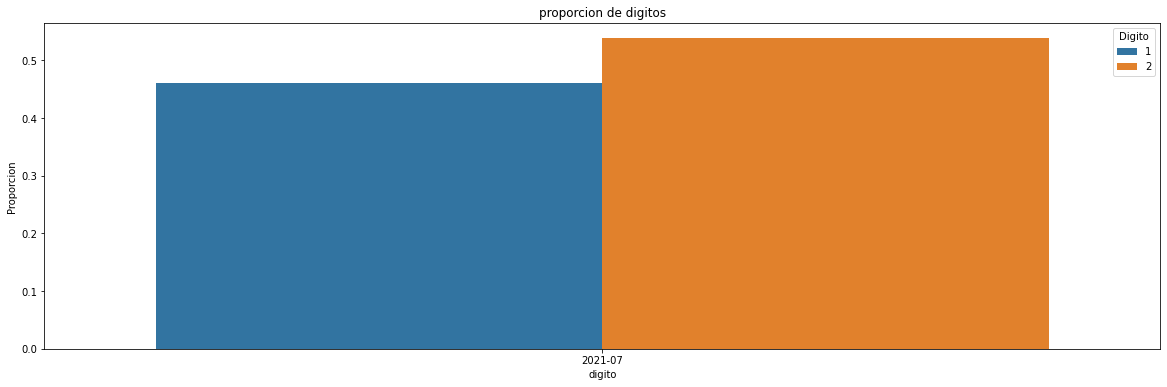

In [243]:
fig, ax = plt.subplots()
fig.set_size_inches(20, 6)
sns.barplot(x=df_count_digits4['year-month'], y = df_count_digits4['Proporcion'], hue=df_count_digits4['Digito'])
plt.xlabel('digito')
plt.ylabel('Proporcion')
plt.title('proporcion de digitos')
plt.show()

<h2>Midiendo la Ley B en las desagregaciones</h2>

In [40]:
pais='Colombia'
nombre_version = 'ESTADISTICO_DIC_2021'
df = querySQL("SELECT * FROM SCAC_AV7_DesagregacionPronosticoCiudadPlantaDiaTabla WHERE  pais = ? and Version = ?", (pais, nombre_version))
#arreglo de formatos
df['M3Forecast'] = df['M3Forecast'].astype(float)
df['FechaEntrega'] = pd.to_datetime(df['FechaEntrega'])
df['year-month'] = df['FechaEntrega'].dt.to_period('M')

#elimino los dias que tienen volumen cero
df = df[df['M3Forecast']>0]

In [41]:
#creo dos columnas con el digito, uno para el encabezado de conteo y otro para contar
df['primerDigito'] = df['M3Forecast'].apply(first_n_digits)
df['primerDigito_label'] = df['primerDigito']
#conteo de primeros digitos por mes
df_count_digits = df.groupby(['year-month','primerDigito_label']).agg({'primerDigito': 'count'}).reset_index()
#conteo de total primeros digitos por mes
df_count_digits2 = df.groupby(['year-month']).agg({'primerDigito': 'count'}).reset_index()
#hago un merge para poder determinar la proporcion
df_count_digits3 = pd.merge(df_count_digits, df_count_digits2, on=['year-month'], how='inner')

#determino la proporcion de conteo de cada digito
df_count_digits3['Proporcion'] = df_count_digits3['primerDigito_x'] / df_count_digits3['primerDigito_y']

#valores de referencia de la leyB
leyb = pd.read_excel("../datos/leyb.xlsx")

#uno las proporciones obtenidas para compararlas con la ley B
df_count_digits4 = pd.merge(df_count_digits3, leyb, left_on=['primerDigito_label'], right_on=['Digito'], how='inner')

#calculo la desviacion a los valores de referencia
#df_count_digits4['Desviacion_leyB'] = ((df_count_digits4['proporcion_leyB'] - df_count_digits4['Proporcion']).abs())/df_count_digits4['proporcion_leyB']
df_count_digits4['Desviacion_leyB'] = (df_count_digits4['proporcion_leyB'] - df_count_digits4['Proporcion']).abs()
#df_count_digits4

df_desviacion_mensual = df_count_digits4.groupby(['year-month']).agg({'Desviacion_leyB':'sum'}).reset_index()
#df_desviacion_mensual

In [42]:
df_desviacion_mensual

,year-month,Desviacion_leyB
0,2021-12,0.330667


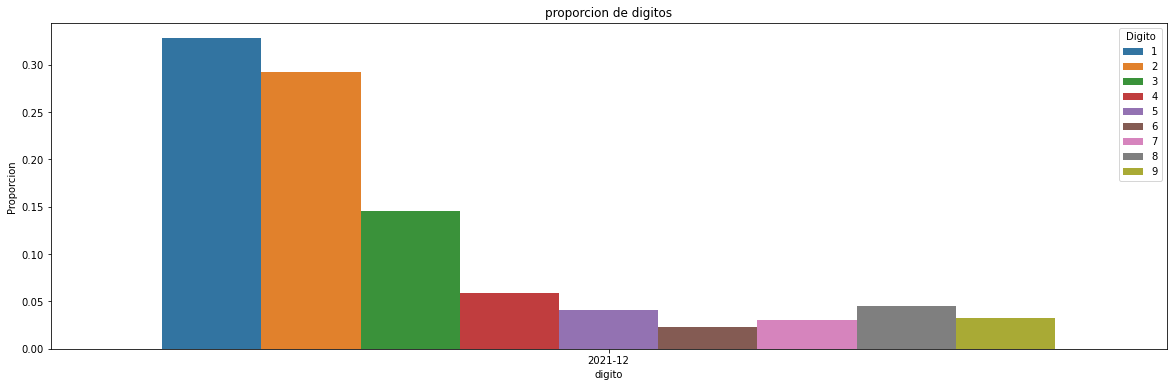

In [43]:
fig, ax = plt.subplots()
fig.set_size_inches(20, 6)
sns.barplot(x=df_count_digits4['year-month'], y = df_count_digits4['Proporcion'], hue=df_count_digits4['Digito'])
plt.xlabel('digito')
plt.ylabel('Proporcion')
plt.title('proporcion de digitos')
plt.show()